<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:36px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Deep Learning for Actuaries</b></div>

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Three interpretable frameworks for an actuarial context</b></div>

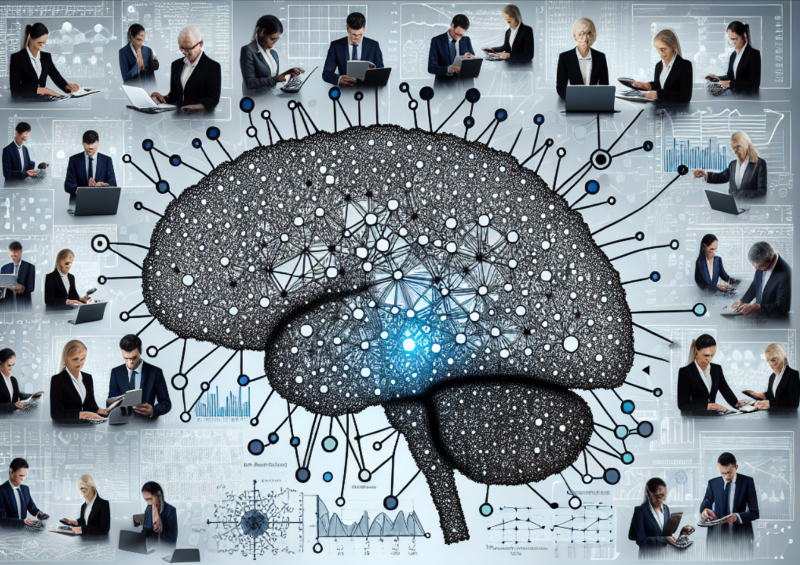  

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Introduction</b></div>

<div style="text-align: justify;">Recent breakthroughs in artificial intelligence (AI) have been largely driven by neural networks, particularly deep learning frameworks. These techniques have revolutionized fields such as image recognition, natural language processing, and predictive analytics.
However, it can be difficult to apply neural networks in actuarial settings. First, neural networks are often considered "black boxes" because of their complex structure with thousands of parameters. Actuaries usually produce rating structures that clearly show how premiums and risk behave over different variables, as transparency and interpretability are crucial in actuarial work. Neural networks though only return a single prediction which makes it much more difficult to interpret model results and provide explanations to stakeholders. Second, most actuarial datasets have a tabular structure, consisting of structured numerical and categorical variables. It has been shown that neural networks and deep learning mainly excel in tasks such as image recognition and language processing <reference>. On tabular data, traditional models such as Generalized Linear Models (GLM) or tree-based models (e.g. Random Forest, GBM) usually perform better.
Recognizing these challenges, deep learning frameworks suited for actuarial problems and tabular data have been developed in the academic community. In this article, we discuss three of these frameworks: the Combined Actuarial Neural Network (CANN), LocalGLMNet and TabNet. We briefly explain the workings of these models and the pros and cons of each method.
</div>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Table of Contents</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
<a id="TOC"></a>
    
* [Code setup](#code_setup)
* [Import libraries and load data](#import)
* [Data Preprocessing](#data_preprocessing)
* [Model Evaluation Functions](#model_evaluation)
* [The GLM benchmark model](#glm)
* [The Combined Actuarial Neural Network](#cann)
* [LocalGLMNet](#localglm)
* [TabNet](#tabnet)
* [Results evaluation](#results)
* [References](#ref)
* [Related Projects](#rel)

<a id="code_setup"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Code setup</b></div>

The python version used for this notebook is 3.10.x

We recommend to create a dedicated Conda environment for this notebook. See the example terminal commands:

Along with the python version, please install:

- Create a new conda environment named 'dl-env' with Python 3.10:
*conda create -n dl-env python=3.10*

- Activate the new environment:
*conda activate dl-env*

- Install the required packages:
*conda install pandas scikit-learn matplotlib numpy*

- Install TensorFlow using pip:
*pip install tensorflow*

- Install PyTorch and torchvision for CPU only:
*conda install pytorch torchvision torchaudio cpuonly -c pytorch*

- and all other remaining packages below

<a id="import"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Import libraries and load data</b></div>

In [65]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_poisson_deviance
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Nadam

from torch import nn
import torch
import torch.autograd as autograd
from skorch import NeuralNetRegressor
from torch.optim import NAdam

from pytorch_tabnet.tab_model import TabNetRegressor

For simplicity and transparency, we use an open source dataset with a portfolio of car insurance policies and claims. The dataset can be loaded from the repository or it can be found on Kaggle (https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq). This is a well-known and often used dataset for modelling. This provides transparency as results can be benchmarked to other work.

In [66]:
# Load the dataset (replace with your actual file path)
#data = pd.read_csv('C:/Users/R0626499/OneDrive - Allianz/Documents/Bart/Actuaris/DL_for_Actuaries/data/freMTPL2freq.csv')
data = pd.read_csv('C:/Users/bart_/Documents/git_repo/DL_for_Actuaries/data/freMTPL2freq.csv')

# Inspect the dataset
data.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [67]:
data.shape

(678013, 12)

<a id="data_preprocessing"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Data Preprocessing</b></div>

The preprocessing is largely based on Richman & Wüthrich (2023), meaning that data in the tails will be right-censored. Furthermore, the Area feature is encoded to be treated as a continuous feature.

The dataset consists of a mix of numerical and categorical features. Many machine learning models cannot process categorical features in their raw format, so we need to One-Hot encode the categorical features. Furthermore, it is common the standardize numerical data before training. Both the standardization and onehot encoding are applied below in a preprocessing pipeline. 

Another important step is the creation of a train and test sample, a 90/10 split will be used.

In [68]:
# Some data preparation
data['Exposure'] = 1 # Set exposure to 1 for simplicity
exposure = data['Exposure']

# Right-censor the data to deal with low observations
data['VehAge'] = data['VehAge'].clip(upper=20)
data['DrivAge'] = data['DrivAge'].clip(upper=90)
data['BonusMalus'] = data['BonusMalus'].clip(upper=150)

# Encode Area as continuous
area_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
data['Area'] = data['Area'].map(area_mapping)

# 5. Remove missing values
data = data.dropna()

# Preprocess the Dataset
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus','Area']
categorical_features = ['VehBrand', 'Region','VehGas']

y = data['ClaimNb']
X = data.drop(columns=['ClaimNb', 'Exposure', 'IDpol'], axis=1)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split the dataset including the exposure
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.1, random_state=42
)

# Apply the preprocessing pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get categorical feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

# Combine numerical and encoded categorical feature names
feature_names = numerical_features + cat_feature_names

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Model Evaluation Functions</b></div>

In this section we will define functions that will evaluate the model performance. As evaluation metrics we chose RMSE, mean absolute error (MAE) and Poisson deviance as they are commonly used for model performance assessment. Furthermore, graphical evaluation will be done through a double lift chart. 

In [69]:
# Dictionary to store evaluation results
model_results = {}

# Function to calculate model performance metrics and store them in a dict
def evaluate_model(model_name, y_true, y_pred):
    rmse = float(root_mean_squared_error(y_true, y_pred))  # Convert to float
    mae = float(mean_absolute_error(y_true, y_pred))  # Convert to float
    poisson_dev = float(mean_poisson_deviance(y_true, y_pred))  # Convert to float

    # Store results in the dictionary
    model_results[model_name] = {
        "RMSE": rmse,
        "MAE": mae,
        "Poisson Deviance": poisson_dev
    }

    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


In [70]:
def double_lift_chart(y_true, y_pred, num_bins=10):
    # Create a DataFrame with true and predicted values
    df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

    # Create deciles based on predicted values
    df['Decile'] = pd.qcut(df['Predicted'], q=num_bins, labels=False)

    # Calculate average actual and predicted values for each decile
    decile_summary = df.groupby('Decile').agg({'Actual': 'mean', 'Predicted': 'mean'}).reset_index()

    # Plot the double lift chart
    plt.figure(figsize=(8, 5))
    plt.plot(decile_summary['Decile'], decile_summary['Actual'], marker='o', label='Actual')
    plt.plot(decile_summary['Decile'], decile_summary['Predicted'], marker='x', label='Predicted')
    plt.xlabel('Decile')
    plt.ylabel('Average Value')
    plt.title('Double Lift Chart')
    plt.legend()
    plt.grid(True)
    plt.show()

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>The GLM benchmark model</b></div>

As a first step and benchmark we will now fit a GLM. As we are predicting claim frequency (count) we will use a Poisson distribution. For this we employ a PoissonRegressor from Scikit learn's linear model library. The only parameter that is defined in the Poisson Regressor is 'alpha', which indicates the regularization strength (the extent to which L2 penalty terms are applied). For this simple implementation we will go with traditional, unpenalized GLMs (alpha=0).  

In [71]:
# Instantiate the Poisson regressor
glm = PoissonRegressor(alpha=0)
glm.fit(X_train, y_train)

PoissonRegressor(alpha=0)

Now the GLM is fitted, we can inspect the features and coefficients:

In [72]:
# Get the coefficients from the model
coefficients = glm.coef_

# Display
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False).drop(columns="Abs_Coefficient")
print(coef_df)

           Feature  Coefficient
19      Region_R23    -0.310495
28      Region_R53     0.291609
3       BonusMalus     0.280360
31      Region_R73    -0.235607
20      Region_R24     0.233436
34      Region_R83    -0.208539
21      Region_R25     0.200424
23      Region_R31    -0.185984
33      Region_R82     0.183471
2          DrivAge     0.179089
30      Region_R72    -0.166583
1           VehAge    -0.165366
32      Region_R74     0.150778
35      Region_R91    -0.134827
14     VehBrand_B5     0.112422
27      Region_R52     0.111502
29      Region_R54     0.098630
38   VehGas_Diesel    -0.091885
10    VehBrand_B14    -0.083858
6     VehBrand_B10    -0.069260
24      Region_R41    -0.065605
18      Region_R22     0.060355
8     VehBrand_B12    -0.056526
36      Region_R93    -0.053081
4             Area     0.049917
26      Region_R43    -0.048182
25      Region_R42     0.046580
22      Region_R26    -0.043340
15     VehBrand_B6    -0.035368
5      VehBrand_B1     0.030330
11     V

For evaluation, we first need to make predictions on our test sample. When predictions on X_test are available, we can call the evaluation function and plot the double lift chart:

In [73]:
# Get GLM predictions
glm_preds_train = glm.predict(X_train)
glm_preds_test = glm.predict(X_test)

In [74]:
# Evaluate GLM
evaluate_model("GLM", y_test, glm_preds_test)

GLM - RMSE: 0.2335, MAE: 0.0991, Poisson Deviance: 0.3080


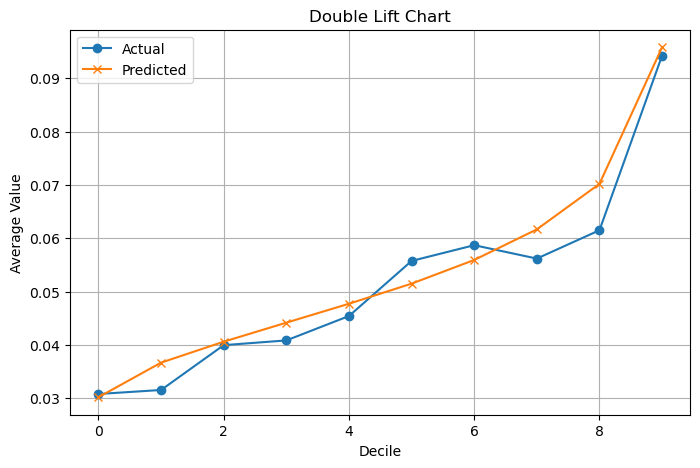

In [75]:
double_lift_chart(y_test, glm_preds_test)

<a id="cann"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>The Combined Actuarial Neural Network</b></div>

**A brief intro to Neural Networks**

A neural network is a model inspired by the structure of the human brain. It consists of multiple layers of interconnected nodes (neurons) that process the data and aim to learn the relationships in the data. The three main components of a neural network are:

•	**Input layer**: This is the layer that processes the input data. Each neuron in this layer represents a feature in the dataset (e.g., policyholder age, claim history, insured amount). 

•	**Hidden layers**: The hidden layers perform complex transformations on the data. Each neuron in a hidden layer takes inputs from the previous layer, applies a transformation and weighting, and then passes the result through an activation function. 

•	**Output layer**: The output layer produces the final prediction for the problem at hand. 

Neural networks are usually trained ‘supervised’, meaning that we give the true labels of our problem to the model. So in a classification problem for example, we will provide the true labels which the model can compare to the predicted labels in a loss function. The neural network then learns by adjusting the weights of connections between the neurons to optimize the loss function. 

**The Combined Actuarial Neural Network (CANN)**

The CANN model, as proposed by Wüthrich & Merz (2019) combines a GLM with a neural network. By using the GLM predictions, the neural network part aims to capture additional patterns that were not captured by the GLM. In the output layer, the final CANN prediction is then obtained by combining the GLM prediction (that arrives via a ‘skip connection’) with the neural network prediction. In this way, CANN retains the interpretability of GLMs while improving predictive performance.

For example implementations of CANN, check:

- https://github.com/freekholvoet/nnforfreqsevpricing
- https://www.kaggle.com/code/floser/use-case-claim-frequency-modeling-python

In [76]:
# Define the GLM predictions for the Skip-layer of CANN
log_glm_preds_train = np.log(glm_preds_train)
log_glm_preds_test = np.log(glm_preds_test)

For the architecture of the neural network part, we will largely follow Wüthrich & Merz (2023). The input layer gets the number of neurons equal to the size of the feature set. Next, three hidden, fully-connected layers are added with ReLu activation. We also experimented with Tanh activation but this did not change results significantly. 

Next the skip connection is added, so that the original GLM predictions arrive in the output layer, jointly with the neural network predictions. The output layer will then produce the final prediction through exponential activation.

Model parameters, such as the number of layers, layer-size, learning rate and batch-size can potentially be tuned, but for simplicity we will continue without hyperparameter tuning.

In [77]:
# Define Input Layer
input_layer = Input(shape=(X_train.shape[1],), name="Design")

# Neural Network layers
hidden1 = layers.Dense(128, activation="relu", name="hidden1")(input_layer)
hidden2 = layers.Dense(64, activation="relu", name="hidden2")(hidden1)
hidden3 = layers.Dense(32, activation="relu", name="hidden3")(hidden2)
nn_output = layers.Dense(1, activation=None, name="Network")(hidden3)

# GLM Skip connection
glm_input = Input(shape=(1,), name="LogGLM")

# Combine GLM and Neural Network Outputs
combined_output = layers.Add(name="Add")([nn_output, glm_input])

# Final Output Layer with exponential activation
final_output = layers.Dense(1, activation="exponential", name="Response")(combined_output)

# Create the model
cann_model = Model(inputs=[input_layer, glm_input], outputs=final_output)
cann_model.get_layer("Response").trainable = False
optimizer = Nadam(learning_rate=0.005)
cann_model.compile(optimizer=optimizer, loss="poisson")
cann_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Design (InputLayer) │ (None, 40)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden1 (Dense)     │ (None, 128)       │      5,248 │ Design[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden2 (Dense)     │ (None, 64)        │      8,256 │ hidden1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden3 (Dense)     │ (None, 32)        │      2,080 │ hidden2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Network (Dense)     │ (None, 1)         │         33 │ hidden3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LogGLM (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Add (Add)           │ (None, 1)         │          0 │ Network[0][0],    │
│                     │                   │            │ LogGLM[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Response (Dense)    │ (None, 1)         │          2 │ Add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,619 (61.01 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 2 (8.00 B)

After defining the model we can train the model below. Many studies train with hundreds of epochs, from the plot below we have concluded that 15-20 epochs are enough for optimal results. More epochs result in overfitting.

In [78]:
# Train the CANN model
history_cann = cann_model.fit(
    [X_train, log_glm_preds_train],
    y_train,
    epochs=15,
    batch_size=4000,
    validation_data=([X_test, log_glm_preds_test], y_test)
)

Epoch 1/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3941 - val_loss: 0.2016
Epoch 2/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2082 - val_loss: 0.2009
Epoch 3/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2062 - val_loss: 0.2010
Epoch 4/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2068 - val_loss: 0.2011
Epoch 5/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2044 - val_loss: 0.2008
Epoch 6/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2059 - val_loss: 0.2002
Epoch 7/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2059 - val_loss: 0.2001
Epoch 8/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2032 - val_loss: 0.2002
Epoch 9/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2055 - val_loss: 0.2008
Epoch 10/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2044 - val_loss: 0.2003
Epoch 11/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2041 - val_loss: 0.2002
Epoch 12/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

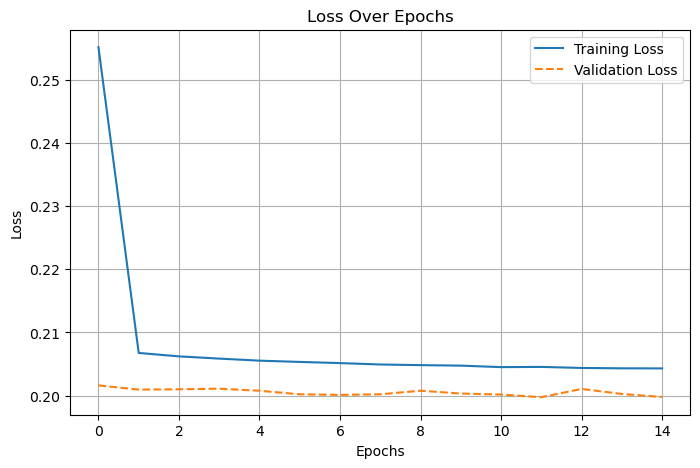

In [79]:
# Plot the loss over the epochs
plt.figure(figsize=(8, 5))
plt.plot(history_cann.history['loss'], label='Training Loss')
plt.plot(history_cann.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
# Evaluate CANN
cann_preds_test = cann_model.predict([X_test, log_glm_preds_test])
cann_preds_test = np.maximum(cann_preds_test, 1e-6)  
evaluate_model("CANN", y_test, cann_preds_test)

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
CANN - RMSE: 0.2329, MAE: 0.0994, Poisson Deviance: 0.3045


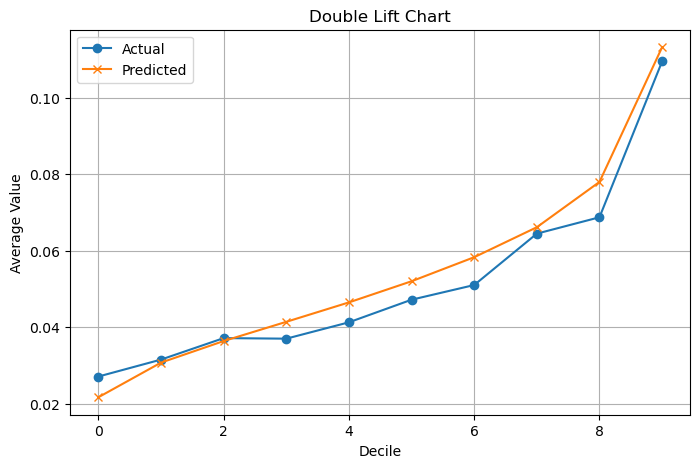

In [81]:
cann_preds_test_adj = np.ravel(cann_preds_test) 
double_lift_chart(y_test, cann_preds_test_adj)

Now let's get some insight into the differences in prediction. For this, we need to inverse the transformations done in the preproccesing step, to obtain a test set with original features. This enhances readability. 

Next, we can plot the predictions of the GLM and CANN per feature to assess how predictions vary and what is essentially the adjustment done by the neural network.

In [ ]:
# Inverse transform the scaled data
scaler = preprocessor.named_transformers_['num']
X_test_dense = X_test.toarray() if isinstance(X_test, csr_matrix) else X_test
X_test_inv_scaled = scaler.inverse_transform(X_test_dense[:, :len(numerical_features)])

# Reversing the OneHotEncoder
encoder = preprocessor.named_transformers_['cat']
cat_feature_names = encoder.get_feature_names_out(categorical_features)
X_test_inv_categorized = encoder.inverse_transform(X_test_dense[:, len(numerical_features):])

# Combine the numerical and categorical back to a dataframe
X_test_inv = np.hstack([X_test_inv_scaled, X_test_inv_categorized])
X_test_inv_df = pd.DataFrame(X_test_inv, columns=numerical_features + categorical_features)

# Add predictions to the dataframe
X_test_inv_df['GLM_Predictions'] = glm_preds_test.ravel()
X_test_inv_df['CANN_Predictions'] = cann_preds_test.ravel()

In [107]:
def plot_feature_comparisons(features, X_test_inv_df):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, feature_name in enumerate(features):
        plot_data = X_test_inv_df.groupby(feature_name)[['GLM_Predictions', 'CANN_Predictions']].mean().reset_index()

        ax = axes[i]
        ax.plot(plot_data[feature_name], plot_data["GLM_Predictions"], label="GLM", linestyle="--", marker="o")
        ax.plot(plot_data[feature_name], plot_data["CANN_Predictions"], label="CANN", linestyle="-", marker="s")

        # Fill the area between the GLM and CANN predictions
        ax.fill_between(plot_data[feature_name], plot_data["GLM_Predictions"], plot_data["CANN_Predictions"],
                        color="salmon", alpha=0.5, label="NN Adjustment")

        ax.set_xlabel(feature_name)
        ax.set_ylabel("Average Predicted Values")
        ax.set_title(f"GLM and CANN Predictions by {feature_name}")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

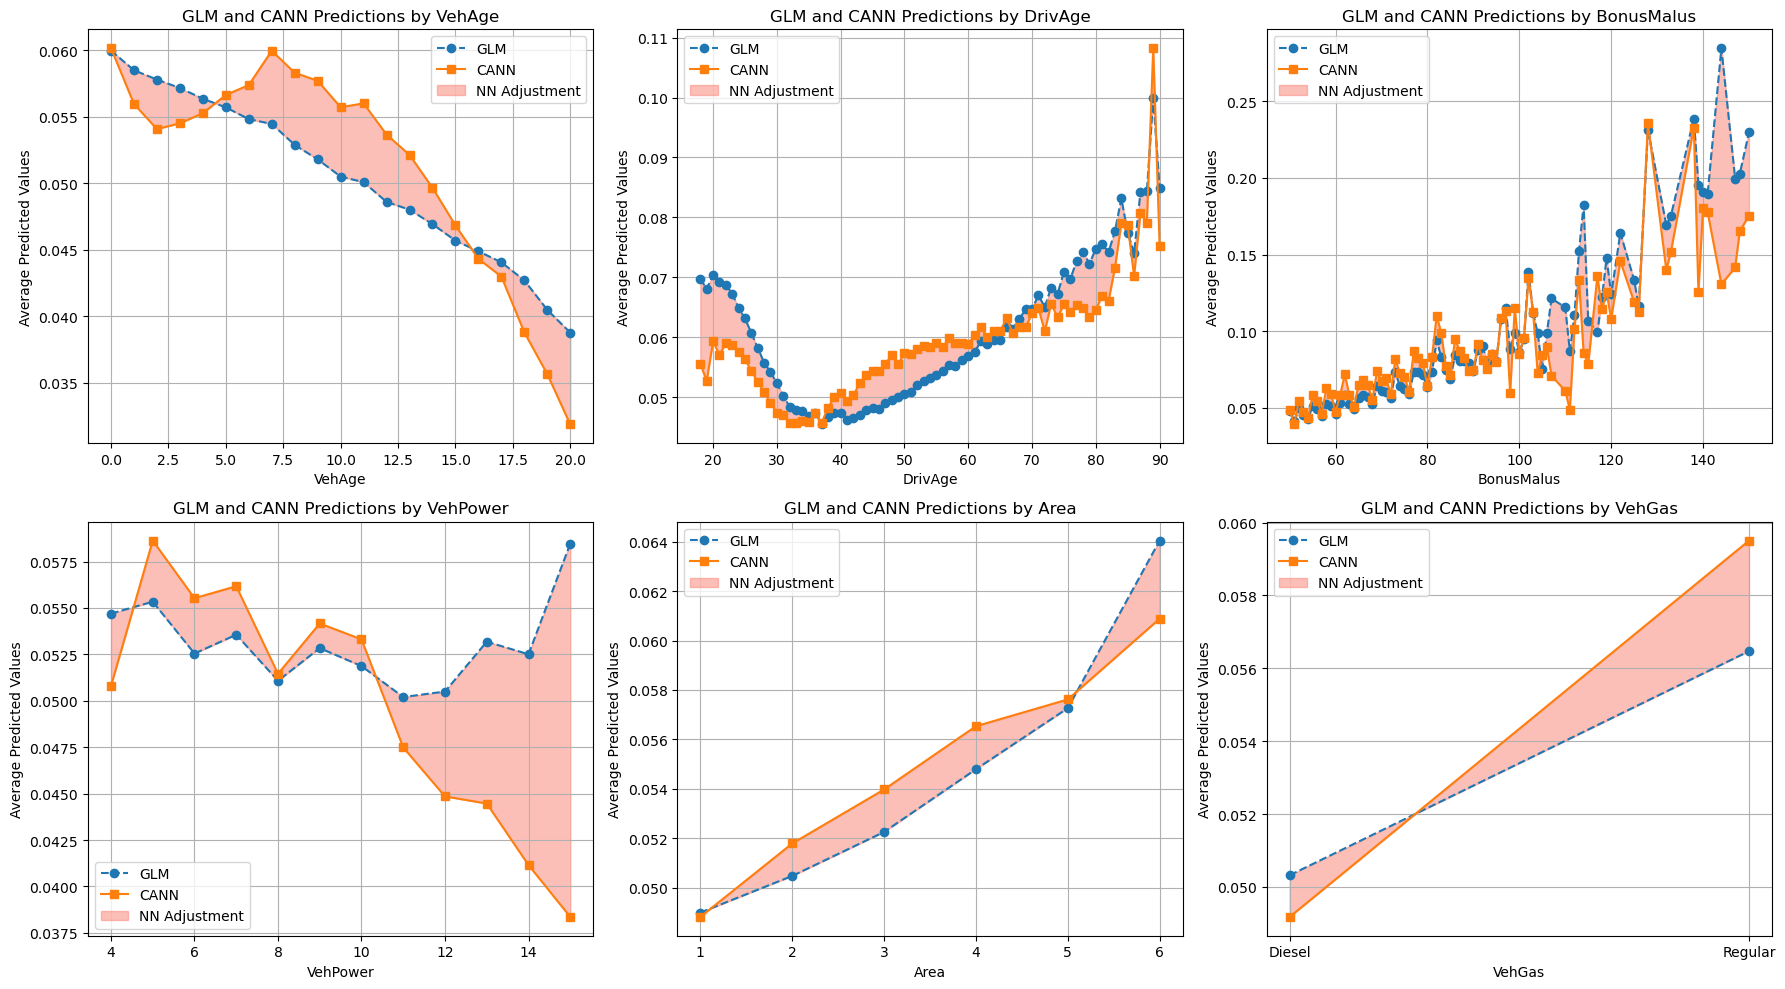

In [108]:
plot_feature_comparisons(['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas'], X_test_inv_df)

<a id="localglm"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>LocalGLMNet</b></div>

INCLUDE REFERENCES!!!!

For example implementations of LocalGLMNet, check:

- https://www.kaggle.com/code/orereisrael/the-state-of-ai-tabular-time-series-data
- https://github.com/neeland/local-glm-net/tree/main/local-glm-net

In [138]:
# Build the LocalGLMNet Model
class LocalGLMNet(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes):
        super(LocalGLMNet, self).__init__()
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(input_size, hidden_layer_sizes[0])]
        )
        self.hidden_layers.extend(
            [
                nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1])
                for i in range(len(hidden_layer_sizes) - 1)
            ]
        )
        self.last_hidden_layer = nn.Linear(hidden_layer_sizes[-1], input_size)
        self.output_layer = nn.Linear(1, 1)
        self.activation = nn.Tanh()
        self.inverse_link = torch.exp

    def forward(self, features, exposure=None, attentions=False):
        x = features
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.last_hidden_layer(x)
        if attentions:
            return x
        skip_connection = torch.einsum("ij,ij->i", x, features).unsqueeze(1)
        x = self.output_layer(skip_connection)
        x = self.inverse_link(x)
        if exposure is None:
            exposure = torch.ones_like(x, device=features.device)
        x = x * exposure
        return x

def train_model(X, v, y, device):
    localglmnet = NeuralNetRegressor(
        module=LocalGLMNet,
        max_epochs=20,
        criterion=nn.PoissonNLLLoss,
        criterion__log_input=False,
        module__input_size=X.shape[1],
        module__hidden_layer_sizes=[128, 64, 32],
        optimizer=NAdam,
        lr=0.005,
        batch_size=4000,
        device=device,
    )

    X_dict = {"features": X, "exposure": v}
    localglmnet.fit(X_dict, y)
    return localglmnet

def extract_contributions_and_gradients(localglmnet, X_val_torch, v_val_torch):

    # Move the model to CPU
    localglmnet_module = localglmnet.module_.to("cpu")

    # Ensure the input tensors are on the CPU
    X_val_torch = X_val_torch.to("cpu")
    v_val_torch = v_val_torch.to("cpu")

    # Get attentions from the PyTorch module forward method by passing attentions=True
    with torch.no_grad():
        unscaled_attentions = localglmnet_module(X_val_torch, exposure=v_val_torch, attentions=True).numpy()

    # Get the scaling factor from the output layer
    scaling = localglmnet_module.output_layer.weight.detach().numpy()

    # Calculate attentions
    attentions = unscaled_attentions * scaling

    # Convert X_val_torch to a NumPy array for multiplication
    X_val = X_val_torch.numpy()

    # Calculate contributions by multiplying attentions with their corresponding feature values
    contributions = np.multiply(attentions, X_val)

    print("attentions shape: ", attentions.shape)

    # Extracting the gradients
    input_tensor = X_val_torch.clone().detach().requires_grad_(True)
    attentions_tensor = localglmnet_module(input_tensor, exposure=v_val_torch, attentions=True)

    n, p = input_tensor.shape
    gradients = np.empty((p, n, p))
    for i in range(p):
        grad_scaling = torch.ones_like(attentions_tensor[:, i])
        gradient_i = autograd.grad(
            attentions_tensor[:, i], input_tensor, grad_scaling, create_graph=True
        )
        gradients[i, :, :] = gradient_i[0].detach().numpy() * scaling

    return attentions, contributions, gradients

In [139]:
# Convert data to PyTorch tensors
X_train_torch = torch.FloatTensor(X_train.toarray())
y_train_torch = torch.FloatTensor(y_train.values)
X_test_torch = torch.FloatTensor(X_test.toarray())
y_test_torch = torch.FloatTensor(y_test.values)

In [140]:
# Train the LocalGLMNet
trained_model = train_model(X_train_torch, np.ones_like(y_train_torch), y_train_torch, device='cpu')

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.2224        0.2124  27.2085
      2        0.2096        0.2125  28.0633
      3        0.2097        0.2125  25.0668
      4        0.2097        0.2124  24.4358
      5        0.2096        0.2124  23.7424
      6        0.2096        0.2124  24.3310
      7        0.2096        0.2124  24.3965
      8        0.2096        0.2124  24.6998
      9        0.2096        0.2123  23.7245
     10        0.2096        0.2123  26.0010
     11        0.2096        0.2123  27.7614
     12        0.2096        0.2123  25.6046
     13        0.2096        0.2123  23.2132
     14        0.2096        0.2123  24.0989
     15        0.2096        0.2123  26.2288
     16        0.2096        0.2123  26.9700
     17        0.2096        0.2123  26.7598
     18        0.2096        0.2123  27.6324
     19        0.2096        0.2122  27.8722
     20        0.2095        0.2122  27.7010


In [141]:
# Evaluate LocalGLMNet
localglmnet_preds_test = trained_model.predict(X_test_torch)
evaluate_model("LocalGLMNet", y_test, localglmnet_preds_test)

LocalGLMNet - RMSE: 0.2342, MAE: 0.1015, Poisson Deviance: 0.3138


c:\Users\R0626499\Anaconda3\envs\dl-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [142]:
# Example usage (assuming you have a trained model and validation data):
v_val_torch = torch.ones_like(y_test_torch)  # Assuming y_test_torch is a PyTorch tensor

attentions, contributions, gradients = extract_contributions_and_gradients(trained_model, X_test_torch, v_val_torch)

attentions shape:  (67802, 41)


In [143]:
def visualize_gradients(gradients, feature_names=None):
    """
    Visualizes the gradients using a heatmap.

    Parameters:
    gradients: A numpy array of shape (p, n, p) containing gradients
    feature_names: Optional list of feature names for labeling the heatmap
    """
    # Calculate the average gradient magnitude for each feature
    avg_gradients = np.mean(np.abs(gradients), axis=1)

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(avg_gradients, cmap='viridis', xticklabels=feature_names, yticklabels=feature_names)
    plt.title('Average Gradient Magnitude Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

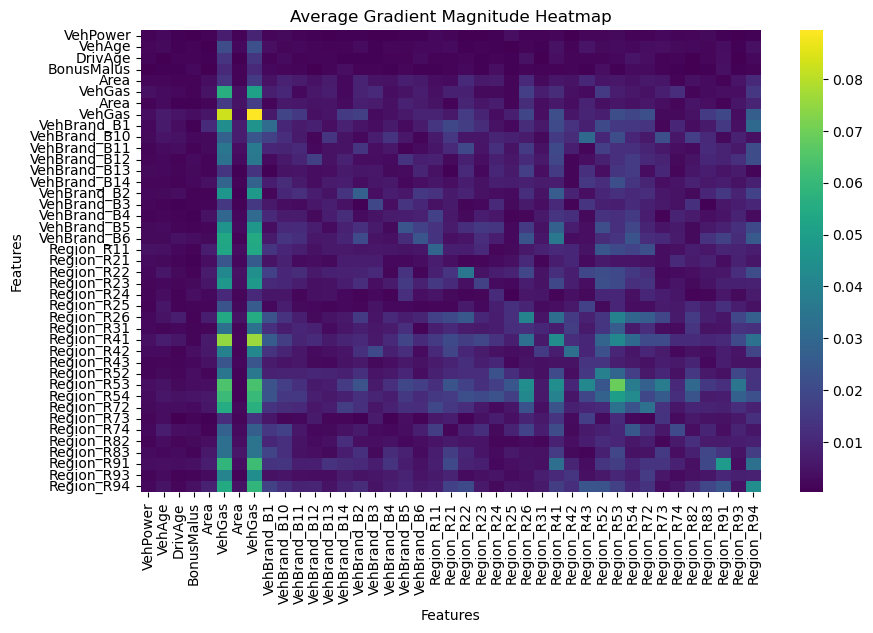

In [144]:
visualize_gradients(gradients, feature_names)

In [54]:

def plot_attention_weights_for_feature(attentions, feature_values, feature_name, is_categorical=False, bins=10):
    """
    Plots the attention weights for a specific feature.

    Parameters:
    attentions: Array of attention weights (n_samples, n_features)
    feature_values: Array of feature values (n_samples,)
    feature_name: Name of the feature to plot
    is_categorical: Whether the feature is categorical
    bins: Number of bins for numerical features
    """
    # Extract attention weights for the specific feature
    feature_index = feature_names.index(feature_name)
    feature_attentions = attentions[:, feature_index]

    if is_categorical:
        # For categorical features, group by category
        data = pd.DataFrame({'Feature': feature_values, 'Attention': feature_attentions})
        attention_means = data.groupby('Feature')['Attention'].mean()
        attention_means.plot(kind='bar', figsize=(10, 6))
        plt.xlabel(feature_name)
        plt.ylabel('Average Attention Weight')
        plt.title(f'Attention Weights for {feature_name}')
    else:
        # For numerical features, bin the feature values
        data = pd.DataFrame({'Feature': feature_values, 'Attention': feature_attentions})
        data['Feature_Binned'] = pd.cut(data['Feature'], bins=bins)
        attention_means = data.groupby('Feature_Binned')['Attention'].mean()
        attention_means.plot(kind='bar', figsize=(10, 6))
        plt.xlabel(f'{feature_name} (Binned)')
        plt.ylabel('Average Attention Weight')
        plt.title(f'Attention Weights for {feature_name}')

    plt.show()

# Example usage:
# Assuming attentions is an array of shape (n_samples, n_features)
# and feature_values is the array of values for the specific feature
plot_attention_weights_for_feature(attentions, X['VehPower'], 'VehPower', is_categorical=False, bins=10)

ValueError: array length 135603 does not match index length 678013

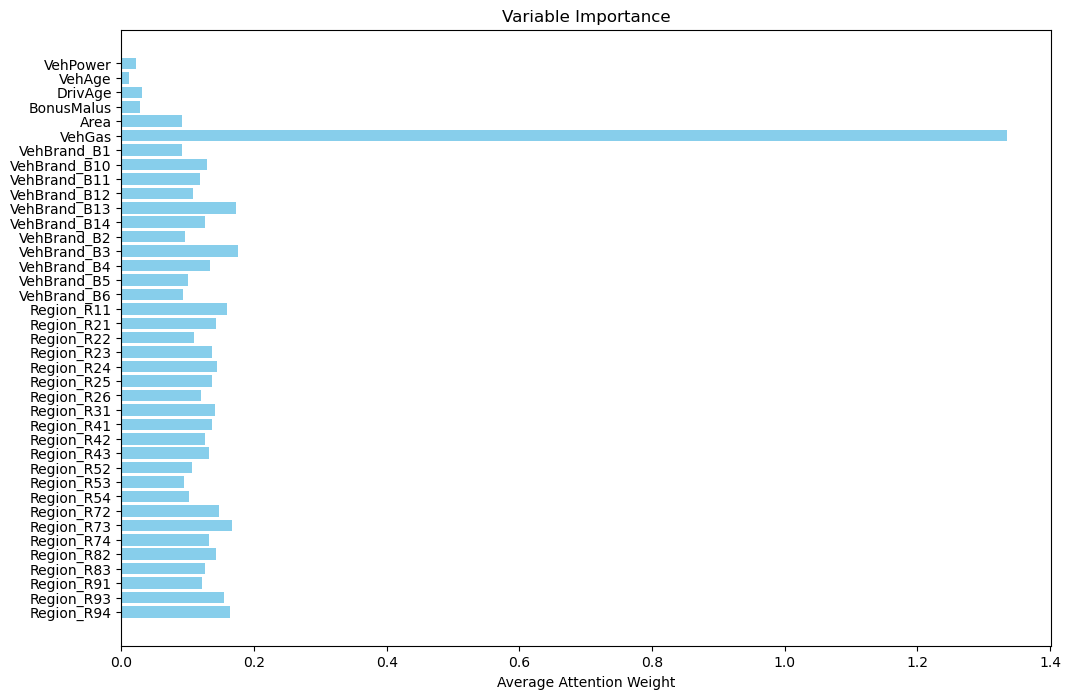

In [145]:
def plot_variable_importance(attentions, feature_names):
    """
    Plots the variable importance based on average attention weights.

    Parameters:
    attentions: Array of attention weights (n_samples, n_features)
    feature_names: List of feature names
    """
    # Calculate the average attention weight for each feature
    avg_absolute_attention_weights = np.mean(np.abs(attentions), axis=0)

    # Create a bar plot for variable importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_names, avg_absolute_attention_weights, color='skyblue')
    plt.xlabel('Average Attention Weight')
    plt.title('Variable Importance')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

# Example usage:
# Assuming attentions is an array of shape (n_samples, n_features)
plot_variable_importance(attentions, feature_names)

<a id="tabnet"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>TabNet</b></div>

For example implementations of TabNet, check:

- https://www.kaggle.com/code/wangqihanginthesky/baseline-tabnet

In [ ]:
# Step 7: Build the TabNet Model
# Initialize and train the TabNet model
tabnet = TabNetRegressor()

y_train_normalized = (y_train / exposure_train).values.reshape(-1, 1)
y_test_normalized = (y_test / exposure_test).values.reshape(-1, 1)

# Train the TabNet model with normalized targets
tabnet.fit(X_train, y_train_normalized,
           eval_set=[(X_test, y_test_normalized)],
           eval_metric=['rmse'],
           max_epochs=10)

# Evaluate TabNet
tabnet_preds_test_normalized = tabnet.predict(X_test)
tabnet_preds_test = tabnet_preds_test_normalized * exposure_test
evaluate_model("TabNet", y_test, tabnet_preds_test)

<a id="results"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Results evaluation</b></div>

In [ ]:
# tbd

<a id="ref"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>References</b></div>

* Ronald Richman and Mario V. Wüthrich. 2023. LocalGLMnet: interpretable deep learning for tabular data. *Scandinavian Actuarial Journal* 2023(1), 71–95.

* Mario V. Wüthrich and Michael Merz. 2019. EDITORIAL: YES, WE CANN! *ASTIN Bulletin* 49(1), 1-3.

* Mario V. Wüthrich and Michael Merz. 2023. Statistical Foundations of Actuarial Learning and its Applications. Springer (open access), https://link.springer.com/book/10.1007/978-3-031-12409-9


<a id="rel"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Related Projects</b></div>